In [104]:
import os
# os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
# import geopandas as gpd
from tqdm.notebook import tqdm
import yaml

In [105]:
import glob

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Configuration

In [106]:
with open('config_extraction.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

path_res = Path(cfg['path_res'])
path_ts = Path(cfg['path_ts'])
path_out = Path(cfg['path_out'])
if path_out.exists() is False:
    path_out.mkdir()
var = cfg['var']

### Coordinates

In [107]:
# load static map of reservoirs
glofas_raster = xr.open_dataset(path_res)['res']

# extract an array of reservoir ID
ids = np.unique(glofas_raster.where(~glofas_raster.isnull(), drop=True))
ids = ids[~np.isnan(ids) & (ids != -9999)]
ids = ids.astype(int)

In [110]:
lon = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
lat = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
for id in tqdm(ids):
    cell = glofas_raster.where(glofas_raster == id, drop=True)
    lon.loc[dict(ResID=id)] = cell.lon.data[0]
    lat.loc[dict(ResID=id)] = cell.lat.data[0]

  0%|          | 0/683 [00:00<?, ?it/s]

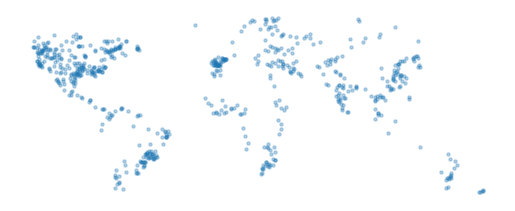

In [111]:
# plot reservoir locations
fig, ax = plt.subplots()
ax.scatter(lon.data, lat.data, s=5, alpha=.3)
ax.set_aspect('equal')
ax.axis('off');

### Time series of reservoir storage

In [ ]:
for file in tqdm(glob.glob(f'{path_ts}/{var}_????.nc')):
    
    # open the dataset lazily using dask
    da = xr.open_dataset(file, chunks='auto')[var]

    # extract data for the reservoirs
    da = da.sel(lon=lon, lat=lat, method='nearest').drop(['lon', 'lat'])
    
    # export extraction
    da.to_netcdf(str(file).replace('.nc', '_extraction.nc'))

***

In [115]:
for file in tqdm(glob.glob(f'{path_ts}/{var}_????.nc')):
    
    # open the dataset lazily using dask
    da = xr.open_dataset(file, chunks='auto')[var]
    
    break

  0%|          | 0/39 [00:00<?, ?it/s]

In [ ]:
    da_extract = xr.DataArray(dims=['time', 'ResID'], coords={'time': da.time, 'ResID': lon.ResID})
    for id in tqdm(ids):
        x, y = lon.sel(ResID=id), lat.sel(ResID=id)
        # extract data for the reservoir 'id'
        da_id = da.sel(lon=x, lat=y, method='nearest')#.drop(['lon', 'lat'])
        da_extract = da_id.compute()

  0%|          | 0/683 [00:00<?, ?it/s]

C:\DEV\Anaconda3\envs\xr\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\DEV\Anaconda3\envs\xr\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\DEV\Anaconda3\envs\xr\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\DEV\Anaconda3\envs\xr\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.


In [ ]:
    # export extraction
    da_extract.to_netcdf(str(file).replace('.nc', '_extraction.nc'))

In [ ]:
    # extract data for the reservoirs
    da = da.sel(lon=lon, lat=lat, method='nearest').drop(['lon', 'lat'])
    
    # export extraction
    da.to_netcdf(str(file).replace('.nc', '_extraction.nc'))

***

In [83]:
import xarray as xr
import pandas as pd
# import cfgrib
import numpy as np
from tqdm.notebook import tqdm

In [85]:
path_ts

WindowsPath('Z:/nahaUsers/casadje/GloFASv4/long_run')

In [88]:
da = xr.open_dataarray(path_ts / 'rsfil_1982_extraction.nc')

da

<xarray.DataArray 'rsfil' (time: 365, ResID: 683)>
[249295 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1981-01-02 1981-01-03 ... 1982-01-01
  * ResID    (ResID) int64 1 2 3 4 5 6 7 8 9 ... 680 681 682 683 684 685 686 687
Attributes:
    standard_name:  ReservoirFillState
    long_name:      ReservoirFill
    units:          m

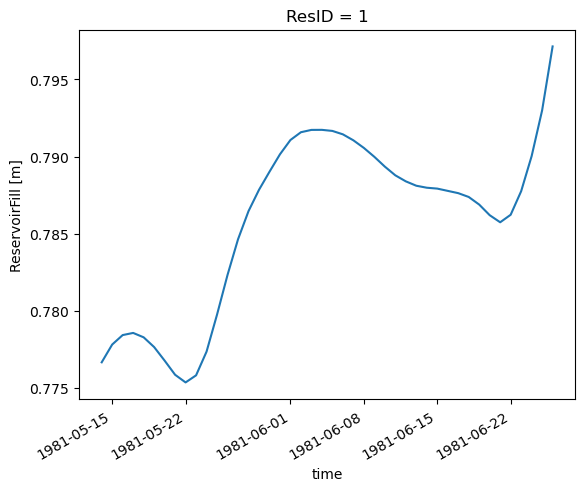

In [89]:
da.sel(ResID=1).plot()

In [ ]:
parameter = "dis24"
filepath = "CDS_GloFASv40_reanalysis/"

for year in np.arange(1980,1981):

    yearstring = str(year)
    
    # load GRIB file
    fullfilepath = filepath + yearstring + '.grib'
    ds = xr.open_dataset(fullfilepath, engine="cfgrib", backend_kwargs={"filter_by_keys": {"typeOfLevel": "surface"}}, chunks={"time": 1})
    
    # load table of points
    df = pd.read_csv("GRDC.csv")
    total = len(df) # number of points
    
    # extract time series for each point
    allIDs = []
    rows_time = []
    rows_value = []
    count = 0
    for lon, lat, id in zip(df.LisfloodX, df.LisfloodY, df.grdc_no):
        
        extracted = ds.sel(longitude=lon, latitude=lat, method="nearest")[parameter]
        print(extracted)
        df_time = extracted.indexes
        df_values = extracted.values
        print("timing 1")
        print("timing 2")
        rows_time.append(df_time._indexes['time'].values[:])
        rows_value.append(df_values)
        print("timing 3")
        count += 1
        print(f"progress: {count/total*100} %")

        allIDs.append(id)

      
    # save time series as CSV
    savefilename = "extracted_test_" + yearstring + ".csv"
    with open(savefilename, "w") as f:
        # header
        f.write("id\ttime\tvalue\n")
        # time series of each point
        for id, time, value in zip(allIDs, rows_time, rows_value):
            for t, v in zip(time,value):
                f.write(f"{id}\t{t}\t{v}\n")

In [ ]:
parameter = "dis24"
filepath = "CDS_GloFASv40_reanalysis/"

for year in np.arange(1980,1981):

    yearstring = str(year)
    
    # load GRIB file
    fullfilepath = filepath + yearstring + '.grib'
    ds = xr.open_dataset(fullfilepath, engine="cfgrib", backend_kwargs={"filter_by_keys": {"typeOfLevel": "surface"}}, chunks={"time": 1})
    
    # load table of points
    df = pd.read_csv("GRDC.csv")
    total = len(df) # number of points
    
    # extract time series for each point
    allIDs = []
    rows_time = []
    rows_value = []
    count = 0
    for lon, lat, id in zip(df.LisfloodX, df.LisfloodY, df.grdc_no):
        
        extracted = ds.sel(longitude=lon, latitude=lat, method="nearest")[parameter]
        print(extracted)
        df_time = extracted.indexes
        df_values = extracted.values
        print("timing 1")
        print("timing 2")
        rows_time.append(df_time._indexes['time'].values[:])
        rows_value.append(df_values)
        print("timing 3")
        count += 1
        print(f"progress: {count/total*100} %")

        allIDs.append(id)

      
    # save time series as CSV
    savefilename = "extracted_test_" + yearstring + ".csv"
    with open(savefilename, "w") as f:
        # header
        f.write("id\ttime\tvalue\n")
        # time series of each point
        for id, time, value in zip(allIDs, rows_time, rows_value):
            for t, v in zip(time,value):
                f.write(f"{id}\t{t}\t{v}\n")